In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# dataset class for preprocessing
class LossTriangleDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        x = np.expand_dims(x, axis=0)  # Add channel dimension
        y = self.labels[index]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

    @staticmethod
    def preprocess_data(dataframe):
        # Drop ay column
        dataframe = dataframe.drop('ay', axis=1)

        # Replace infinity values with NaN
        dataframe.replace([np.inf, -np.inf], np.nan, inplace=True)

        # Remove nan values and normalize data
        scaler = StandardScaler()
        for triangle_id in dataframe['triangle_id'].unique():
            df_triangle = dataframe[dataframe['triangle_id'] == triangle_id].iloc[:, 2:]
            df_triangle = df_triangle.dropna(axis=1, how='all')
            dataframe.loc[dataframe['triangle_id'] == triangle_id, df_triangle.columns] = scaler.fit_transform(df_triangle)

        # Find the maximum number of rows
        max_rows = max([len(dataframe[dataframe['triangle_id'] == triangle_id]) for triangle_id in dataframe['triangle_id'].unique()])

        # Replace "nan" values with 0
        dataframe.fillna(0, inplace=True)


        # Create data and labels
        data = []
        labels = []
        for triangle_id in dataframe['triangle_id'].unique():
            df_triangle = dataframe[dataframe['triangle_id'] == triangle_id].iloc[:, 1:]
            label = df_triangle.iloc[-1, 0]
            triangle_data = df_triangle.iloc[:, 1:].values

            # Zero-padding
            nrows = triangle_data.shape[0]
            padded_triangle_data = np.zeros((max_rows, max_rows))
            for row_idx, row_data in enumerate(triangle_data):
                padded_triangle_data[row_idx, :max_rows-row_idx] = row_data[:max_rows-row_idx]

            data.append(padded_triangle_data)
            labels.append(label)

        # Convert data and labels to numpy arrays
        data = np.stack(data, axis=0)
        labels = np.array(labels)

        # Check if there are any "nan" or infinite values in the data and labels
        assert not np.isnan(data).any(), "Data contains 'nan' values"
        assert not np.isinf(data).any(), "Data contains infinite values"
        assert not np.isnan(labels).any(), "Labels contain 'nan' values"
        assert not np.isinf(labels).any(), "Labels contain infinite values"

        return data, labels

    @staticmethod
    def create_datasets(dataframe, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
        data, labels = LossTriangleDataset.preprocess_data(dataframe)
        train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=test_ratio, random_state=42)
        train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=val_ratio / (train_ratio + val_ratio), random_state=42)

        train_dataset = LossTriangleDataset(train_data, train_labels)
        val_dataset = LossTriangleDataset(val_data, val_labels)
        test_dataset = LossTriangleDataset(test_data, test_labels)

        return train_dataset, val_dataset, test_dataset


In [18]:
test_dataset

NameError: ignored

In [3]:
# cnn model class
class LossTriangleClassifier(nn.Module):
    def __init__(self, input_shape, num_classes=2, dropout_rate=0.5):
        super(LossTriangleClassifier, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=(2, 2), padding=(1, 1))
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=(2, 2), padding=(1, 1))
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=(2, 2), padding=(1, 1))
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)


        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(self._get_flattened_size(input_shape), 512)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool1(F.leaky_relu(self.conv1(x), 0.1))
        x = self.pool2(F.leaky_relu(self.conv2(x), 0.1))
        x = self.pool3(F.leaky_relu(self.conv3(x), 0.1))

        x = self.flatten(x)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)

        return torch.sigmoid(x)

    def _get_flattened_size(self, input_shape):
        dummy_input = torch.zeros(1, *input_shape)
        # dummy_output = self.pool3(F.leaky_relu(self.conv3(self.pool2(F.leaky_relu(self.conv2(self.pool1(F.leaky_relu(self.conv1(dummy_input)))))))))
        dummy_output = self.pool3(F.leaky_relu(self.bn3(self.conv3(self.pool2(F.leaky_relu(self.bn2(self.conv2(self.pool1(F.leaky_relu(self.bn1(self.conv1(dummy_input))))))))))))
        return dummy_output.numel()


In [4]:
# # cnn model class
# class LossTriangleClassifier2(nn.Module):
#     def __init__(self, input_shape, num_classes=2, dropout_rate=0.5):
#         super(LossTriangleClassifier2, self).__init__()

#         self.conv1 = nn.Conv2d(1, 16, kernel_size=(2, 2), padding=(1, 1), bias=False)
#         self.bn1 = nn.BatchNorm2d(16)
#         # self.pool1 = nn.MaxPool2d(2, 2)

#         self.conv2 = nn.Conv2d(16, 32, kernel_size=(2, 2), padding=(1, 1), bias=False)
#         self.bn2 = nn.BatchNorm2d(32)
#         # self.pool2 = nn.MaxPool2d(2, 2)

#         self.conv3 = nn.Conv2d(32, 64, kernel_size=(2, 2), padding=(1, 1), bias=False)
#         self.bn3 = nn.BatchNorm2d(64)
#         # self.pool3 = nn.MaxPool2d(2, 2)

#         self.conv4 = nn.Conv2d(64, 32, kernel_size=(2, 2), padding=(1, 1), bias=False)
#         self.bn4 = nn.BatchNorm2d(32)

#         self.conv5 = nn.Conv2d(32, 16, kernel_size=(2, 2), padding=(1, 1), bias=False)
#         self.bn5 = nn.BatchNorm2d(16)

#         self.flatten = nn.Flatten()

#         self.fc1 = nn.Linear(self._get_flattened_size(input_shape), 512)
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(512, num_classes)
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.fc3 = nn.Linear(512, num_classes)
#         self.dropout3 = nn.Dropout(dropout_rate)
#         self.fc4 = nn.Linear(512, num_classes)
#         self.dropout4 = nn.Dropout(dropout_rate)
#         self.fc5 = nn.Linear(512, num_classes)
#         # self.dropout5 = nn.Dropout(dropout_rate)

#     def forward(self, x):
#         x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2)
#         x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
#         x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
#         x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
#         x = F.leaky_relu(self.bn5(self.conv5(x)), 0.2)

#         x = self.flatten(x)
#         x = F.leaky_relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = self.dropout2(F.leaky_relu(self.fc2(x)))
#         x = self.dropout3(F.leaky_relu(self.fc3(x)))
#         x = self.dropout4(F.leaky_relu(self.fc4(x)))
#         x = self.fc5(x)

#         return torch.sigmoid(x)

#     def _get_flattened_size(self, input_shape):
#         dummy_input = torch.zeros(1, *input_shape)
#         dummy_output = self.conv5(
#             self.bn5(
#                 F.leaky_relu(
#                     self.conv4(
#                         self.bn4(
#                             F.leaky_relu(
#                                 self.conv3(
#                                     self.bn3(
#                                         F.leaky_relu
#                 self.bn4(
#             F.leaky_relu(
#                 self.conv3(
#                     F.leaky_relu(
#                         self.conv2(
#                             F.leaky_relu(
#                                 self.conv1(
#                                     dummy_input
#                                             ))))))
#         # dummy_output = self.pool3(F.leaky_relu(self.bn3(self.conv3(self.pool2(F.leaky_relu(self.bn2(self.conv2(self.pool1(F.leaky_relu(self.bn1(self.conv1(dummy_input))))))))))))
#         return dummy_output.numel()


In [5]:
# train model function
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset), correct / total



In [6]:
# validate model function
def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct / total

    return epoch_loss, epoch_accuracy



In [20]:
# train the model:
def main(datafile='naic.feather', num_epochs = 200):
    # Load data
    dataframe = pd.read_feather(datafile)
    print(f'data head: \n{dataframe.head()}')
    train_dataset, val_dataset, test_dataset = LossTriangleDataset.create_datasets(dataframe)

    # print(f"train set: {train_dataset}")
    # print(f"validation set: {val_dataset}")

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # print(f"train loader: {train_loader}")

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"device: {device}")

    # Initialize model, criterion, and optimizer
    input_shape = train_dataset[0][0].shape
    model = LossTriangleClassifier(input_shape).to(device)
    # criterion = nn.BCELoss()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00001)

    # print(f"input_shape: {input_shape}")
  

    # Train and validate model
    
    train_list, val_list = [], []
    t_acc_list, v_acc_list = [], []
    for epoch in range(num_epochs):
        train_loss, t_acc = train_model(model, train_loader, criterion, optimizer, device)
        val_loss, v_acc = validate_model(model, val_loader, criterion, device)
        train_list.append(train_loss)
        val_list.append(val_loss)
        t_acc_list.append(t_acc)
        v_acc_list.append(v_acc)
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Training Loss: {train_loss:.4f} / Validation Loss: {val_loss:.4f}')
        print(f'Training Accuracy: {t_acc:.1%}  / Validation Accuracy: {v_acc:.1%}')

    # Test the model
    model.eval()
    test_predictions = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            test_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())

    # Print the predictions
    print("Predictions on the test set:", test_predictions)

    return train_list, val_list, t_acc_list, v_acc_list, test_predictions, test_dataset

In [30]:
train_loss, val_loss, train_acc, val_acc, test_pred, test_dataset = main('/content/drive/MyDrive/naic.feather', 300)

data head: 
   triangle_id  is_cum    ay       1        2        3        4        5  \
0            0       1  1988   133.0    333.0    431.0    570.0    615.0   
1            0       1  1989   934.0   1746.0   2365.0   2579.0   2763.0   
2            0       1  1990  2030.0   4864.0   6880.0   8087.0   8595.0   
3            0       1  1991  4537.0  11527.0  15123.0  16656.0  17321.0   
4            0       1  1992  7564.0  16061.0  22465.0  25204.0  26517.0   

         6        7       8       9     10  
0    615.0    615.0   614.0   614.0  614.0  
1   2966.0   2940.0  2978.0  2978.0    NaN  
2   8743.0   8763.0  8762.0     NaN    NaN  
3  18076.0  18308.0     NaN     NaN    NaN  
4  27124.0      NaN     NaN     NaN    NaN  
device: cuda
Epoch 1/1000
Training Loss: 0.6932 / Validation Loss: 0.6929
Training Accuracy: 50.4%  / Validation Accuracy: 59.8%
Epoch 2/1000
Training Loss: 0.6924 / Validation Loss: 0.6924
Training Accuracy: 52.6%  / Validation Accuracy: 65.6%
Epoch 3/1000
Tra

In [31]:
test = pd.DataFrame(dict(yhat=test_pred, y=test_dataset.labels))
test['correct'] = test.yhat==test.y
test.correct.sum() / test.shape[0]

0.8740978348035284

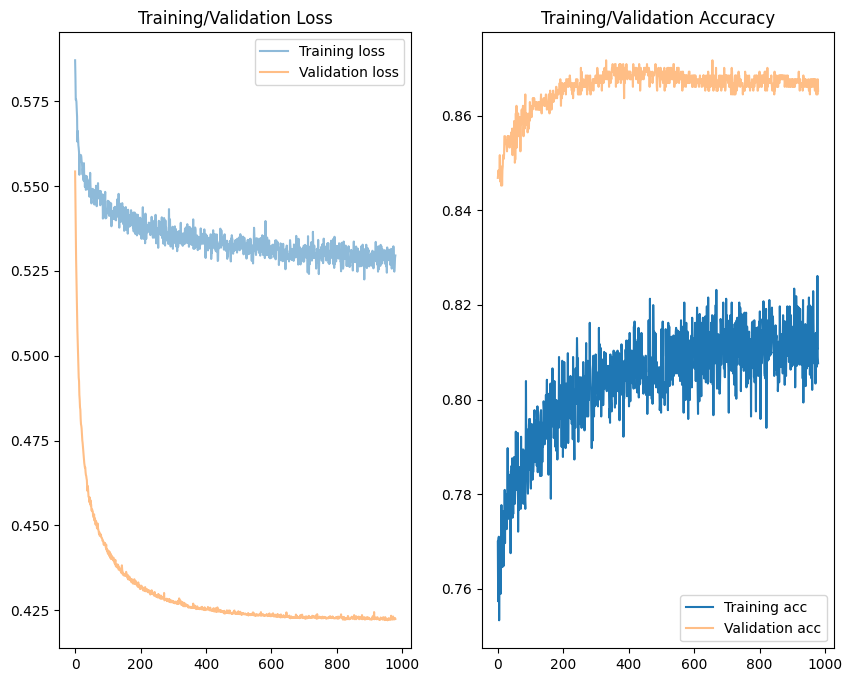

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].plot(train_loss[20:], label='Training loss', alpha=0.5)
ax[0].plot(val_loss[20:], label='Validation loss', alpha=0.5)
ax[0].set_title('Training/Validation Loss')
ax[0].legend()

ax[1].plot(train_acc[20:], label='Training acc')
ax[1].plot(val_acc[20:], label='Validation acc', alpha=0.5)
ax[1].set_title('Training/Validation Accuracy')
ax[1].legend()

plt.show()

In [17]:
test_pred

[0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
